In [3]:
# FUNCTION AND MODULES
import networkx as nx
import gzip
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def load_network(file_path):
    """
    Load a weighted network from a gzipped tab-separated file into a NetworkX graph.
    The file should contain three columns: node1, node2, and weight.
    """
    G = nx.Graph()
    with gzip.open(file_path, 'rt') as file:  # 'rt' mode for reading text
        for line in file:
            parts = line.strip().split()
            if len(parts) == 3:
                node1, node2, w = parts
                if node1 != 'protein1' and node2 != 'protein2':
                    G.add_edge(node1, node2)
            else:
                continue  # skip lines that do not match the expected format

    return G

def get_list_known_complexes(path_known_complexes):
    # Load known protein complexes from CSV file
    complexes_df = pd.read_csv(path_known_complexes, sep='\t')
    complexes_df = complexes_df[['#Complex ac',  'Recommended name', 'Expanded participant list']]
    complexes_df['Expanded participant list'] = [components.split('|') for components in complexes_df['Expanded participant list']]
    # Extract identifiers from components
    complexes_df['Components'] = complexes_df['Expanded participant list'].apply(lambda x: [component.split('(')[0] for component in x if not component.startswith('CHEBI')])
    complexes_df['N_of_Components'] = [len(components) for components in complexes_df['Components']]
                                       
    list_of_complexes=[row['Components'] for i, row in complexes_df.iterrows() if len(row['Components'])>1]

    for i, complex in enumerate(list_of_complexes):
        for j, protein in enumerate(complex):
            if '-PRO_' in protein:
                list_of_complexes[i][j]=protein.split('-')[0]

    total_ids=[]
    for complex in list_of_complexes:
        total_ids.extend(complex)
    list_total_protein_ids_in_complexes=list(set(total_ids))
    print(len(list_of_complexes))

    complexes_df = complexes_df[['#Complex ac', 'Recommended name', 'Components', 'N_of_Components' ]]
    return list_of_complexes, list_total_protein_ids_in_complexes, complexes_df


def maps_clusters_to_Uniprot_AC(mapping, clusters):
    clusters = [[mapping[net_code] for net_code in cluster] for cluster in clusters]
    return clusters

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))**0.5
    return intersection / union

def get_list_clusters(id_mapper, path_clustering):
    # Load clusters from JSON file
    with open(path_clustering, 'r') as f:
        found_clusters = json.load(f)
    found_clusters_Uni_AC=maps_clusters_to_Uniprot_AC(id_mapper, found_clusters)
    return found_clusters_Uni_AC


def get_mapping(path_to_alias, list_total_protein_ids_in_complexes, mapper_id_=False):
    alias = pd.read_csv(path_to_alias, delimiter='\t')

    id_mapper={}
    mapper_id={}

    for i, row in alias.iterrows():
        # print(row)
        # print(row['source'])
        if row['source'] == 'RefSeq_xref_UniProtKB_Swiss_Prot' or row['source'] == 'UniProt_AC':
            if row['alias'] in list_total_protein_ids_in_complexes:
                id_mapper[row['#string_protein_id']]=row['alias']
                mapper_id[row['alias']]=row['#string_protein_id']

    for i, row in alias.iterrows():
        if row['#string_protein_id'] not in id_mapper.keys():
            if row['source'] == 'RefSeq_xref_UniProtKB_Swiss_Prot':
                    id_mapper[row['#string_protein_id']]=row['alias']
                    mapper_id[row['alias']]=row['#string_protein_id']

    for i, row in alias.iterrows():
        if row['#string_protein_id'] not in id_mapper.keys():
            if row['source'] == 'UniProt_AC':
                    id_mapper[row['#string_protein_id']]=row['alias']
                    mapper_id[row['alias']]=row['#string_protein_id']
                    
    if not mapper_id_:
        return id_mapper
    else:
        return mapper_id


# FUNCTIONS FOR METRICS

def get_best_match_complexes(clusters, complexes):
    # Confronta ogni cluster con i complessi noti
    results = {}
    for i, complex_set in enumerate(complexes):
        complex_set = set(complex_set)
        max_coverage = 0
        max_similarity = 0
        best_match = None
        for j, cluster in enumerate(clusters):
            cluster_set = set(cluster)
            coverage = len(cluster_set.intersection(complex_set)) / len(complex_set)
            similarity = jaccard_similarity(complex_set, cluster_set)
            if coverage > max_coverage:
                max_coverage = coverage
                max_similarity = similarity
                best_match = j
            elif  coverage == max_coverage:
                if similarity > max_similarity:
                    max_coverage = coverage
                    max_similarity = similarity
                    best_match = j
        if max_coverage>0.75:
            results[i]=({
                'Match': best_match,
                'Similarity': max_similarity,
                'Coverage': max_coverage,
            })

    return results

def precision_recall_fmeasure(best_complexes_match, found_clusters, actual_complexes):

    true_positives_clusters = len(best_complexes_match)
    total_clusters = len(found_clusters)
    total_complexes = len(actual_complexes)
    
    
    precision = true_positives_clusters / total_clusters
    recall = true_positives_clusters / total_complexes
    f_measure = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0
    
    return precision, recall, f_measure

def evaluate_clusters(found_clusters, actual_complexes):
    
    # Find matching complexes
    best_complexes_match = get_best_match_complexes(found_clusters, actual_complexes)
    precision, recall, f_measure = precision_recall_fmeasure(best_complexes_match, found_clusters, actual_complexes)
        
    # Create a DataFrame with the results
    results_df = pd.DataFrame({
        "Precision": [precision],
        "Recall": [recall],
        "F_measure": [f_measure],
    })
    
    return results_df


#### Results evaluation

In [6]:
# Setting the path to the files

path_known_complexes='./data/83333.tsv'
file_path_alias='./data/511145.protein.aliases.v12.0.txt.gz'

In [7]:
# Loading the data of experimentally determined Complexes
actual_complexes, list_total_protein_ids_in_complexes, complexes_df = get_list_known_complexes(path_known_complexes)
complexes_df

288


,#Complex ac,Recommended name,Components,N_of_Components
0,CPX-28,p-aminobenzoyl-glutamate hydrolase complex,"[P76052, P77357]",2
1,CPX-93,MutS DNA mismatch repair complex,[P23909],1
2,CPX-180,HipBA toxin-antitoxin complex,"[P23873, P23874]",2
3,CPX-243,Respiratory chain complex I,"[P0AFC3, P0AFC7, P0AFD1, P0AFD4, P0AFD6, P0AFE...",13
4,CPX-268,Cytochrome bd-I ubiquinol oxidase complex,"[P0ABJ9, P0ABK2, P56100]",3
...,...,...,...,...
319,CPX-3176,Endopeptidase ClpXP complex,"[P0A6G7, P0A6H1]",2
320,CPX-3178,Endopeptidase ClpP complex,[P0A6G7],1
321,CPX-3190,"Taurine dioxygenase complex, dimeric",[P37610],1
322,CPX-3206,Acetyl-CoA carboxylase complex,"[P0A9Q5, P0ABD5, P0ABD8, P24182]",4


In [9]:
# Creating a mapper between ids. The file 83333.tsv file containing information about known protein complexes uses a 
# set of identifier to refers to proteins e.x. P76052 and P77357 commonly used in order to avoid ambiguity. The network insted 
# uses a specific protein identifiers used by the STRING database. They also provide, in the file 511145.protein.aliases.v12.0.txt.gz, 
# for each node all the different aliases it can have, in order to be able to retrive each node to which proteins referes 

# Creation of a mapper to map nodes to their id in order to compare it to the knwon complexes
id_mapper = get_mapping(file_path_alias, list_total_protein_ids_in_complexes)

In [11]:
# OH-PIN - Final metrics
resolutions =  [0.10, 0.25, 0.5, 1, 2.5, 4.5]
df_metrics = pd.DataFrame()

for lamdba in resolutions:
    path_clustering=f'./511145_clustering/OHPIN_clusters_{lamdba}.json'
    
    # Loading the cluster
    found_clusters = get_list_clusters(id_mapper, path_clustering)
    
    # Calulating the metrics
    metrics = evaluate_clusters(found_clusters, actual_complexes)
    metrics['Resolution'] = lamdba
    metrics['NumClusters'] = len(found_clusters)
    metrics['Algorithm'] = 'OH-PIN'
    
    # Append to the df
    df_metrics = pd.concat([df_metrics, metrics], ignore_index=True)

df_metrics_OHPIN = df_metrics[['Algorithm', 'NumClusters', 'Resolution', 'Precision', 'Recall', 'F_measure']]
display(df_metrics_OHPIN)

,Algorithm,NumClusters,Resolution,Precision,Recall,F_measure
0,OH-PIN,1029,0.10,0.271137,0.965398,0.423369
1,OH-PIN,510,0.25,0.549020,0.968858,0.700876
2,OH-PIN,351,0.50,0.797721,0.968858,0.875000
3,OH-PIN,302,1.00,0.927152,0.968858,0.947547
4,OH-PIN,275,2.50,1.018182,0.968858,0.992908
5,OH-PIN,221,4.50,1.266968,0.968858,1.098039


In [12]:
# Louvain - Final metrics
resolutions = [4, 6, 7, 11, 35, 220]
resolutions.reverse()   
df_metrics = pd.DataFrame()

for resolution in resolutions:
    path_clustering=f'./511145_clustering/louvain_clusters_{resolution}.json'
    
    # Loading the cluster
    found_clusters = get_list_clusters(id_mapper, path_clustering)
    
    # Calulating the metrics
    metrics = evaluate_clusters(found_clusters, actual_complexes)
    metrics['Resolution'] = resolution
    metrics['NumClusters'] = len(found_clusters)
    metrics['Algorithm'] = 'Louvain'
    
    # Append to the df
    df_metrics = pd.concat([df_metrics, metrics], ignore_index=True)
    
df_metrics_Louvain = df_metrics[['Algorithm', 'NumClusters', 'Resolution', 'Precision', 'Recall', 'F_measure']]
df_metrics_Louvain


,Algorithm,NumClusters,Resolution,Precision,Recall,F_measure
0,Louvain,1068,220,0.084270,0.311419,0.132646
1,Louvain,532,35,0.321429,0.591696,0.416565
2,Louvain,352,11,0.502841,0.612457,0.552262
3,Louvain,294,7,0.619048,0.629758,0.624357
4,Louvain,278,6,0.654676,0.629758,0.641975
5,Louvain,229,4,0.803493,0.636678,0.710425


In [13]:
# Girvan-Newman - Other metrics
resolutions =  [1000, 500, 300, 275, 220]
results = []
df_metrics = pd.DataFrame()

for resolution in resolutions:
    path_clustering=f'./511145_clustering/clusters_Girvan-Newman_{resolution}.json'
    
    # Loading the cluster
    found_clusters = get_list_clusters(id_mapper, path_clustering)
    
    # Calulating the metrics
    metrics = evaluate_clusters(found_clusters, actual_complexes)
    metrics['Resolution'] = '-'
    metrics['NumClusters'] = len(found_clusters)
    metrics['Algorithm'] = 'Girvan-Newman'
    
    # Append to the df
    df_metrics = pd.concat([df_metrics, metrics], ignore_index=True)
    
df_metrics_GirvanNewman = df_metrics[['Algorithm', 'NumClusters', 'Resolution', 'Precision', 'Recall', 'F_measure']]
df_metrics_GirvanNewman

,Algorithm,NumClusters,Resolution,Precision,Recall,F_measure
0,Girvan-Newman,1003,-,0.192423,0.667820,0.298762
1,Girvan-Newman,500,-,0.444000,0.768166,0.562738
2,Girvan-Newman,373,-,0.630027,0.813149,0.709970
3,Girvan-Newman,276,-,0.851449,0.813149,0.831858
4,Girvan-Newman,220,-,1.081818,0.823529,0.935167


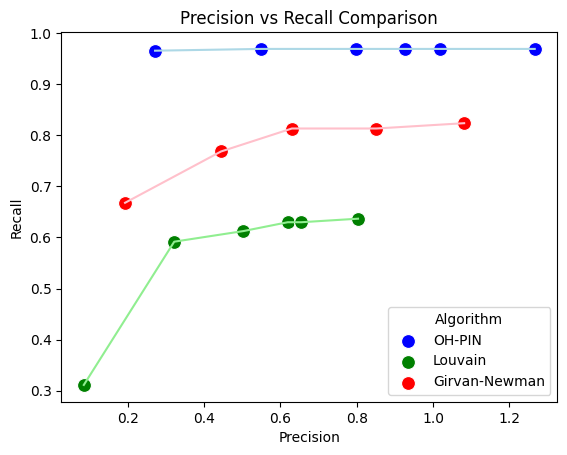

In [14]:
# Plot

# Scatter plot with labels for legend
sns.scatterplot(data=df_metrics_OHPIN, x='Precision', y='Recall', s=100, color="blue", label="OH-PIN")
sns.scatterplot(data=df_metrics_Louvain, x='Precision', y='Recall', s=100, color="green", label="Louvain")
sns.scatterplot(data=df_metrics_GirvanNewman, x='Precision', y='Recall', s=100, color="red", label="Girvan-Newman")

# Draw lines with labels
plt.plot(df_metrics_OHPIN['Precision'], df_metrics_OHPIN['Recall'], color='lightblue')
plt.plot(df_metrics_Louvain['Precision'], df_metrics_Louvain['Recall'], color='lightgreen')
plt.plot(df_metrics_GirvanNewman['Precision'], df_metrics_GirvanNewman['Recall'], color='pink')

# Adding the legend
plt.legend(title="Algorithm")

# Optional: Add titles and labels
plt.title('Precision vs Recall Comparison')
plt.xlabel('Precision')
plt.ylabel('Recall')

# Show plot
plt.show()

Text(0, 0.5, 'Numvber of Clusters found')

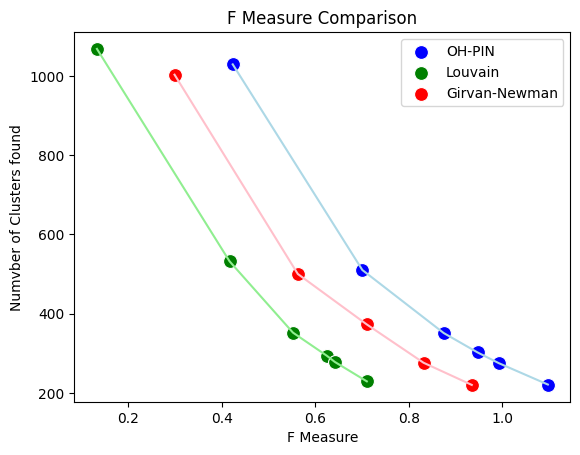

In [15]:
# Plot

# Scatter plot
sns.scatterplot(data=df_metrics_OHPIN, x='F_measure', y='NumClusters', s=100, color="blue", label="OH-PIN")
sns.scatterplot(data=df_metrics_Louvain, x='F_measure', y='NumClusters', s=100, color="green", label="Louvain")
sns.scatterplot(data=df_metrics_GirvanNewman, x='F_measure', y='NumClusters', s=100, color="red", label="Girvan-Newman")

# Draw lines
plt.plot(df_metrics_OHPIN['F_measure'], df_metrics_OHPIN['NumClusters'], color='lightblue')
plt.plot(df_metrics_Louvain['F_measure'], df_metrics_Louvain['NumClusters'], color='lightgreen')
plt.plot(df_metrics_GirvanNewman['F_measure'], df_metrics_GirvanNewman['NumClusters'], color='pink')

# Optional: Add titles and labels
plt.title('F Measure Comparison')
plt.xlabel('F Measure')
plt.ylabel('Numvber of Clusters found')